# Model Comparisson


### Import libraries

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns

### Visualize examples

#### Get original Image and Mask

In [9]:
# Get all files in validation folder
path_images = '/home/juandres/semillero_bcv/hubmap/data/processed/validation/images_with_gt'

# Get files
files = os.listdir(path_images)

print('Number of Val Images : ',len(files))

# Choose an image
selected_img = files[10]

# Load original image and mask
orig_image = Image.open(os.path.join(path_images,selected_img))

# Load mask 

Number of Val Images :  245


In [10]:
def get_all_images(name_image):

    '''
    With the path of the original image, get the original mask and the prediction made by each one of the models
    
    INPUT:
        * name_image : Name of the image contained under data/processed/validation
    OUTPUT:
        * Original image: Input image for prediction
        * Images : Original Mask (first position) and Predicted masks
        * Names : Name of all the models contain in an array of strings
    '''
    # Path to data folder
    base_path = '/home/juandres/semillero_bcv/hubmap/data'

    # Get models predictions
    models = os.listdir(os.path.join(base_path,'models_output'))

    # Load the original image
    orig_img = np.array(Image.open(os.path.join(base_path,'processed','validation','images_with_gt',name_image+'.tif')))

    # Variable for containing all masks
    masks = []

    # Load original mask 
    masks.append(np.array(Image.open(os.path.join(base_path,'processed','validation','masks',name_image+'.png'))))

    # Load the prediction of the rest of the models
    [masks.append(np.array(Image.open(os.path.join(base_path, 'models_output', model, name_image + '.png')))) for model in models]
    
    # Convert to np array and squeeze
    masks = np.array(masks).squeeze()
    masks = masks[:,:,:,0]

    return orig_img,masks,models

def get_metrics(pred_mask,gt_mask):

    # Calculate Jaccard Index
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)

    # Piexl accuracy
    correct_pixels = np.sum(np.logical_and(pred_mask, gt_mask)) + np.sum(np.logical_and(np.logical_not(pred_mask), np.logical_not(gt_mask)))    
    total_pixels = pred_mask.size
    pixel_accuracy = correct_pixels / total_pixels


    # Return all metrics
    metrics = [iou,pixel_accuracy]
    
    return metrics
    

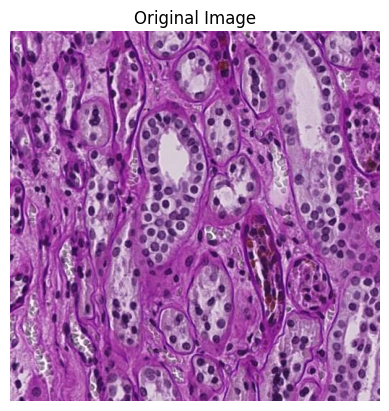

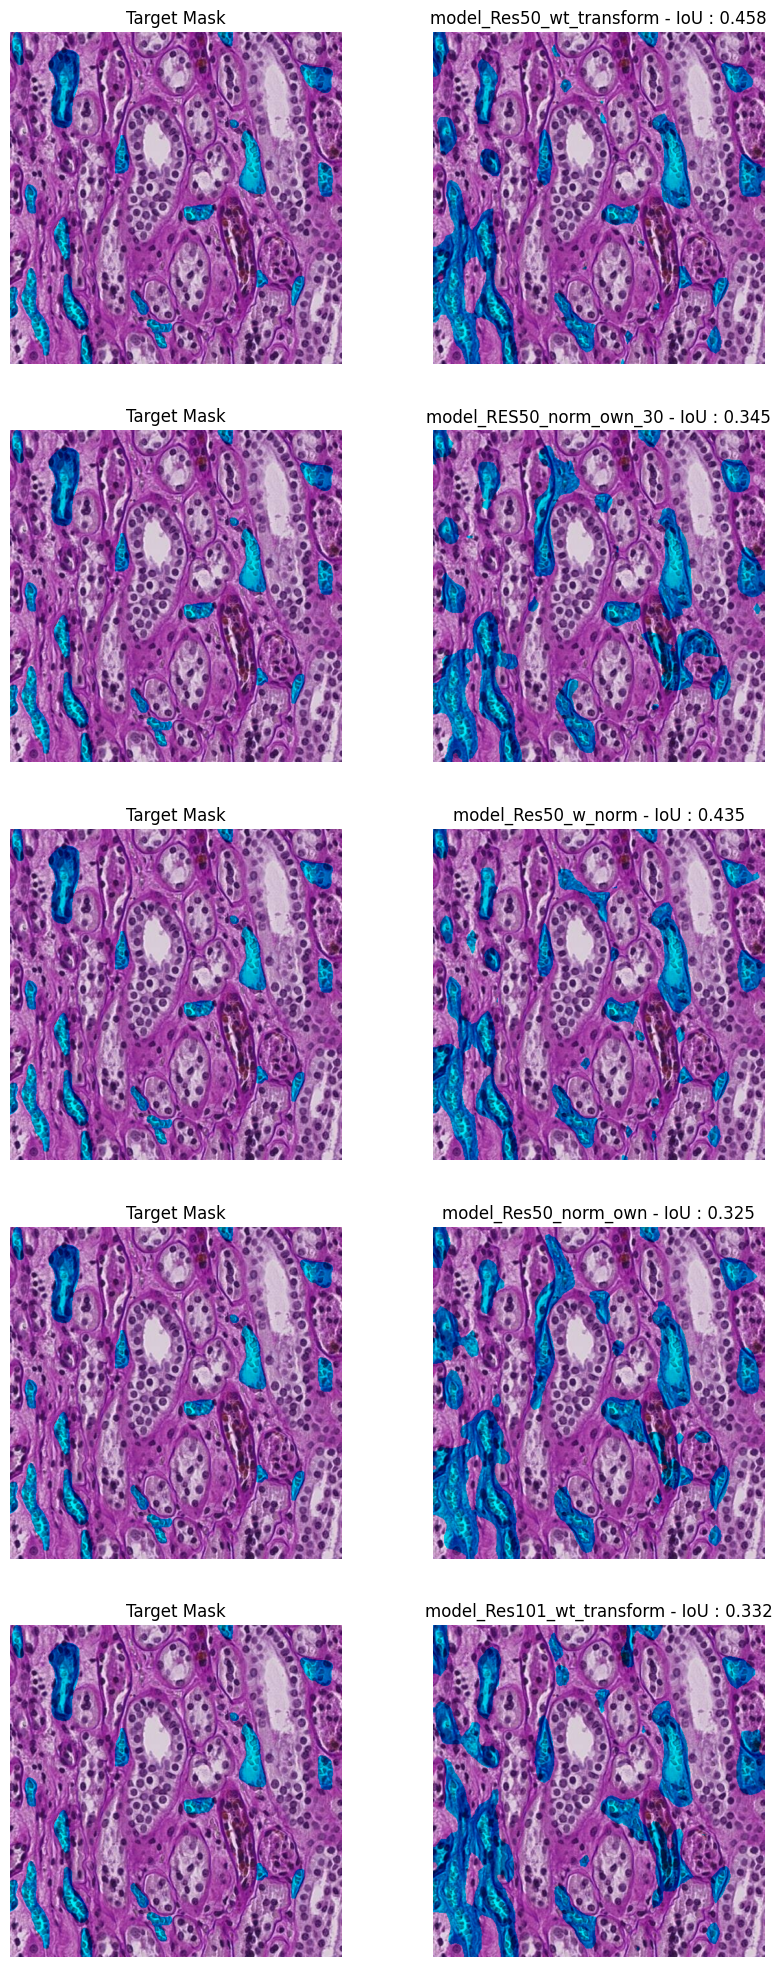

In [11]:

# List all files in validation
all_val_files = os.listdir('/home/juandres/semillero_bcv/hubmap/data/processed/validation/images_with_gt')

# Select number of file
num_file = 120

# Get predictions of a single image
input_img, masks, models = get_all_images(all_val_files[num_file].split('.tif')[0])
plt.imshow(input_img)
plt.axis('off')
plt.title('Original Image')

# Show results
fig,ax = plt.subplots(len(models),2,figsize=(10,len(models)*5))

# Original with mask
im_mask = np.copy(input_img)
im_mask[:,:,0][masks[0,:,:] == 255] = 1

for i in range(0,len(models)):

    # Get metrics
    metrics = get_metrics(masks[i+1,:,:],masks[0,:,:])

    # Image with predicted mask
    im_mask_pred = np.copy(input_img)
    im_mask_pred[:,:,0][masks[i+1,:,:] == 255] = 1
    
    ax[i,0].imshow(im_mask)
    ax[i,1].imshow(im_mask_pred)

    ax[i,0].set_title('Target Mask')
    ax[i, 1].set_title(models[i] + ' - IoU : {:.3f}'.format(metrics[0]))

    ax[i,0].axis('off')
    ax[i,1].axis('off')


### Get metrics

In [12]:
# Create empty df for metrics
columns = ['id','Model','source_wsi','dataset','IoU','Pixel_accuracy']
all_metrics = []

# Load metadata
tile_meta = pd.read_csv('/home/juandres/semillero_bcv/hubmap/data/raw/tile_meta.csv')

# Iterate over all validation images

for i,val_file in enumerate(all_val_files):  

    # Get file name
    name = val_file.split('.tif')[0]

    # Get images
    input_img, masks, models = get_all_images(name)

    # Get original mask
    gt_mask = masks[0,:,:]

    # Iterate over all predicted masks and get metrics

    for j in range(0,len(models)):

        # Get metrics of predicted mask
        metrics = get_metrics(masks[j+1,:,:],gt_mask)                

        # Append results to df
        all_metrics.append({
            columns[0] : name,
            columns[1] : models[j],
            columns[2] : tile_meta[tile_meta['id'] == name]['source_wsi'].iloc[0],
            columns[3] : tile_meta[tile_meta['id'] == name]['dataset'].iloc[0],
            columns[4] : metrics[0],
            columns[5] : metrics[1],
        })


    if i % 50 == 0:
        print('Img # : ',i)

all_metrics = pd.DataFrame(all_metrics)



Img # :  0


Img # :  50
Img # :  100
Img # :  150
Img # :  200


#### IoU analyis

In [21]:
all_metrics.groupby('Model')[['IoU','Pixel_accuracy']].mean().sort_values('IoU',ascending=False)

,IoU,Pixel_accuracy
Model,,
model_Res50_wt_transform,0.350742,0.932062
model_Res50_w_norm,0.340743,0.936876
model_Res101_wt_transform,0.288499,0.910851
model_RES50_norm_own_30,0.277110,0.915995
model_Res50_norm_own,0.274852,0.910277


<Axes: xlabel='IoU', ylabel='Model'>

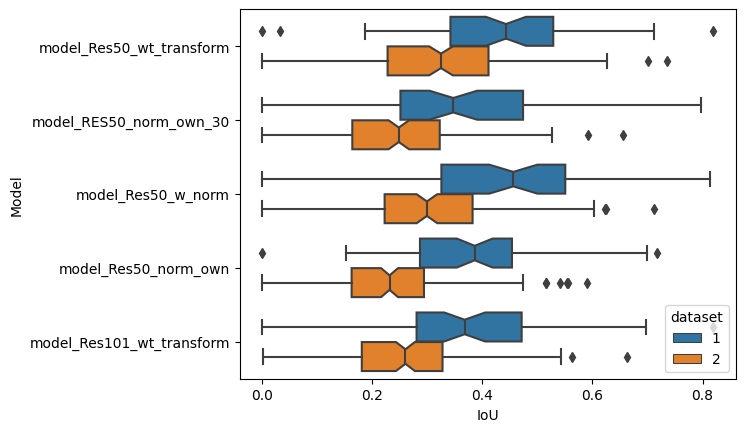

In [25]:
sns.boxplot(data = all_metrics,y = 'Model',x = 'IoU',hue = 'dataset',notch = True)

<Axes: xlabel='Pixel_accuracy', ylabel='Model'>

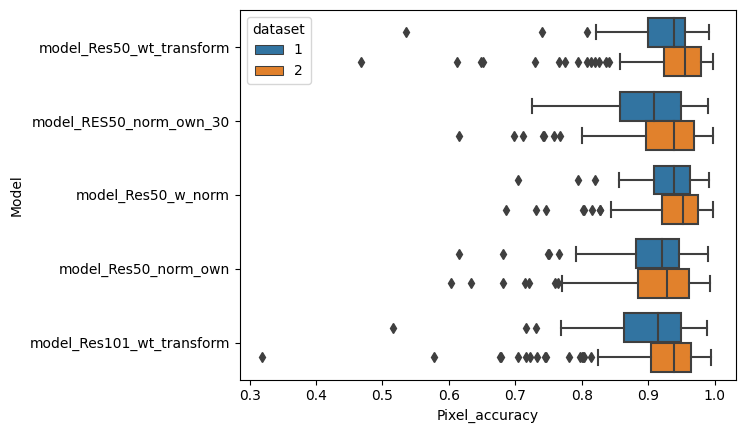

In [29]:
sns.boxplot(data = all_metrics,y = 'Model',x = 'Pixel_accuracy',hue = 'dataset')